In [1]:
! pip3 install numpy pandas matplotlib tqdm 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt

dataset = pd.read_csv('new-thyroid.csv')
dataset.head()

,2,3,4,5,6,class
0,107,10.1,2.2,0.9,2.7,1
1,113,9.9,3.1,2.0,5.9,1
2,127,12.9,2.4,1.4,0.6,1
3,109,5.3,1.6,1.4,1.5,1
4,105,7.3,1.5,1.5,-0.1,1


In [2]:
unique_classes = dataset["class"].unique()
classes_number = len(unique_classes)

In [3]:
dictionary = {}
for i in range(classes_number):
    dictionary[unique_classes[i]] = i
# dictionary = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

{1: 0, 2: 1, 3: 2}


In [5]:
n = dataset.shape[0]
m = dataset.shape[1] - 1

dataset["class"] = dataset.apply(lambda x: dictionary[x[m]], axis = 1)

In [6]:
dataset.head()

,2,3,4,5,6,class
0,107,10.1,2.2,0.9,2.7,0
1,113,9.9,3.1,2.0,5.9,0
2,127,12.9,2.4,1.4,0.6,0
3,109,5.3,1.6,1.4,1.5,0
4,105,7.3,1.5,1.5,-0.1,0


In [7]:
# normalizing 
# (x - min) / (max - min) for each column 

max_values = {}
min_values = {}
for key in dataset:
    if key == 'class':
        continue
    print(key)
    for value in dataset[key]:
        if key not in max_values:
            max_values[key] = value
            min_values[key] = value
        else:
            max_values[key] = max(max_values[key], value)
            min_values[key] = min(min_values[key], value)

for key in dataset.columns:
    if key == 'class':
        continue                       
    dataset[key] = dataset.apply(lambda x: (x[key] - min_values[key]) / (max_values[key] - min_values[key]), axis = 1)

dataset.head()

2
3
4
5
6


,2,3,4,5,6,class
0,0.531646,0.387097,0.204082,0.014210,0.059649,0
1,0.607595,0.379032,0.295918,0.033748,0.115789,0
2,0.784810,0.500000,0.224490,0.023091,0.022807,0
3,0.556962,0.193548,0.142857,0.023091,0.038596,0
4,0.506329,0.274194,0.132653,0.024867,0.010526,0


In [8]:
import os

def write_dataset(dataset, n, m, metric, kernel, window, window_parameter, excluded_row_index, input_file_name):
    input_file = open(input_file_name, 'w')
    input_file.write(f"{n - 1} {m}\n")
    training_rows_indices = list(range(0, n))
    training_rows_indices.remove(excluded_row_index)
    for j in training_rows_indices:
        for key in dataset:
            input_file.write(f"{dataset[key][j]} ")
        input_file.write('\n')
    for key in dataset:
            if key == 'class':
                continue
            input_file.write(f"{dataset[key][excluded_row_index]} ")
    input_file.write('\n')
    input_file.write(metric + '\n')
    input_file.write(kernel + '\n')
    input_file.write(window + '\n')
    input_file.write(str(window_parameter))
    input_file.close()

In [9]:
def get_prediction(input_file_name, output_file_name):
    os.system(f"./prediction {input_file_name} {output_file_name}")
    output_file = open(output_file_name, 'r')
    return int(round(float(output_file.read())))

In [10]:
def get_f_score(input_file_name, output_file_name, confusion_matrix):
    np.savetxt(input_file_name, confusion_matrix, fmt = '%3.0d')
    os.system(f"./f-score {input_file_name} {output_file_name}")
    output_file = open(output_file_name, 'r')
    return float(output_file.read())

In [11]:
def get_f_score_native(classes_number, confusion_matrix):
    rows_sums = np.zeros((1, classes_number), dtype = np.int32)
    columns_sums = np.zeros((1, classes_number), dtype = np.int32)
    all_sum = 0
    for i in range(classes_number):
        for j in range(classes_number):
            value = confusion_matrix[i][j]
            rows_sums[0][i] += value
            columns_sums[0][j] += value
            all_sum += value
    
    average_precision = 0.0
    average_recall = 0.0
    for i in range(classes_number):
        value = confusion_matrix[i][i]
        TP = value
        FP = rows_sums[0][i] - value
        FN = columns_sums[0][i] - value
        
        precision = 0.0
        if TP + FP != 0:
            precision = (float(TP)) / (float(TP + FP))
        recall = 0.0
        if TP + FN != 0:
            recall = (float(TP)) / (float(TP + FN))
        
        average_precision += rows_sums[0][i] * precision
        average_recall += rows_sums[0][i] * recall
    
    macro_f = 2.0 * average_precision * average_recall / (average_precision + average_recall) / all_sum
    
    return macro_f

In [12]:
def uniform(u):
    if (abs(u) >= 1):
        return 0
    return 0.5

def triangular(u):
    a = abs(u)
    if (a >= 1):
        return 0
    return 1 - a

def epanechnikov(u):
    if (abs(u) >= 1):
        return 0
    return 0.75 * (1 - u * u)

def quartic(u):
    if (abs(u) >= 1):
        return 0
    s = (1 - u * u)
    return 0.9375 * s * s

def triweight(u):
    if (abs(u) >= 1):
        return 0
    s = (1 - u * u)
    return 1.09375 * s * s * s

def tricube(u):
    a = abs(u)
    if (a >= 1):
        return 0
    s = (1 - u * u * u)
    return (70 * s * s * s) / 81

def gaussian(u):
    gaussianDenom = 1.0 / np.sqrt(2 * np.pi)
    return np.exp(-0.5 * u * u) / gaussianDenom

def cosine(u):
    if (abs(u) >= 1):
        return 0
    return np.pi / 4 * np.cos(np.pi / 2 * u)

def logistic(u):
    return 1.0 / (np.exp(u) + 2 + np.exp(-u))

def sigmoid(u):
    return 2 / np.pi * 1.0 / (np.exp(u) + np.exp(-u))

kernel_functions = {
    "uniform":      uniform,
    "triangular":   triangular,
    "epanechnikov": epanechnikov,
    "quartic":      quartic,
    "triweight":    triweight,
    "tricube":      tricube,
    "gaussian":     gaussian,
    "cosine":       cosine,
    "logistic":     logistic,
    "sigmoid":      sigmoid,
}

def manhattan(l, r):
    return np.sum(abs(l - r))

def euclidean(l, r):
    x = abs(l - r)
    return np.sqrt(np.sum(x*x))

def chebyshev(l, r):
    return np.max(abs(l - r))

distance_functions = {
    "manhattan": manhattan,
    "euclidean": euclidean,
    "chebyshev": chebyshev,
}

In [13]:
from numpy import delete

def predict(xDataFrame, y, t, kernel, dist, wType, h):
    local_distances = []
    
    def fixed(h):
        return h
    
    def variable(h):
        return local_distances[h][0]

    windows = {
        "fixed":    fixed,
        "variable": variable
    }
    
    x = delete(xDataFrame.values, m, 1)
    z = zip(x, y)
    window = windows[wType]
    t = t.values
    local_distances = list(map(lambda p: (dist(p[0], t[0]), p[1]), z))
    local_distances.sort(key=lambda p: p[0])
    
    num = 0.0
    denom = 0.0
    
    for p in local_distances:
        w = window(h)
        d = p[0]
        if w == 0:
            if d == 0:
                arg = 0
            else:
                arg = 100
        else:
            arg = d / w
            
        k = kernel(arg)
        num += p[1] * k
        denom += k
    
    if (denom == 0):
        result = np.sum(y) / (n - 1)
    else:
        result = num / denom
    
    return result
    

In [14]:
import math
from tqdm import tqdm

metrics = ['manhattan', 'euclidean', 'chebyshev']
kernels = ['uniform', 'triangular', 'epanechnikov', 'quartic', 'triweight', 'tricube', 'gaussian', 'cosine', 'logistic', 'sigmoid']
windows = ['fixed', 'variable']

min_h = 0
max_h_train = 10
max_h_best = 25
# h_step = math.ceil((max_h - min_h) / 20)
h_step = 1

min_k = 1
max_k_train = 10
max_k_best = 25
# k_step = math.ceil((max_k - min_k) / 20)
k_step = 1

input_file_name = 'input.txt'
output_file_name = 'output.txt'

best_metric = metrics[0]
best_kernel = kernels[0]
best_window = windows[0]
best_window_parameter = 1

best_f_score = 0.0

for metric in tqdm(metrics):
    for kernel in tqdm(kernels):
        for window in tqdm(windows):
            if window == 'fixed':
                for h in range(min_h, max_h_train + 1, h_step):
                    confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
                    for excluded_row_index in range(n):
#                         write_dataset(dataset, n, m, metric, kernel, window, h, excluded_row_index, input_file_name)
#                         predicted_class = get_prediction(input_file_name, output_file_name)
                        
                        t = dataset.loc[[excluded_row_index]]
                        train = dataset.drop(excluded_row_index, axis = 0)
                        test = t.drop("class", axis=1)
                        y = train["class"].values
                        predicted_class = int(round(predict(train, y, test, kernel_functions[kernel], distance_functions[metric], window, h)))
                        
                        real_class = dataset['class'][excluded_row_index]
                        confusion_matrix[real_class][predicted_class] += 1
                        
                    f_score = get_f_score_native(classes_number, confusion_matrix)
            
                    if f_score > best_f_score:
                        best_f_score = f_score
                        best_metric = metric
                        best_kernel = kernel
                        best_window = window
                        best_window_parameter = h
            else:
                for k in range(min_k, max_k_train + 1, k_step):
                    confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
                    for excluded_row_index in range(n):
#                         write_dataset(dataset, n, m, metric, kernel, window, k, excluded_row_index, input_file_name)
#                         predicted_class = get_prediction(input_file_name, output_file_name)
                        
                        t = dataset.loc[[excluded_row_index]]
                        train = dataset.drop(excluded_row_index, axis = 0)
                        test = t.drop("class", axis=1)
                        y = train["class"].values
                        predicted_class = int(round(predict(train, y, test, kernel_functions[kernel], distance_functions[metric], window, k)))
                        
                        real_class = dataset['class'][excluded_row_index]
                        confusion_matrix[real_class][predicted_class] += 1
                        
                    f_score = get_f_score_native(classes_number, confusion_matrix)
            
                    if f_score > best_f_score:
                        best_f_score = f_score
                        best_metric = metric
                        best_kernel = kernel
                        best_window = window
                        best_window_parameter = k
 
print(f"f score: {best_f_score}")
print(f"metric: {best_metric}")
print(f"kernel: {best_kernel}")
print(f"window type: {best_window}")
print(f"window parameter: {best_window_parameter}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:06<00:06,  6.96s/it]

100%|██████████| 2/2 [00:12<00:00,  6.32s/it]

 10%|█         | 1/10 [00:12<01:53, 12.65s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:06<00:06,  7.00s/it]

100%|██████████| 2/2 [00:12<00:00,  6.37s/it]

 20%|██        | 2/10 [00:25<01:41, 12.68s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:07<00:07,  7.16s/it]

100%|██████████| 2/2 [00:12<00:00,  6.18s/it]

 30%|███       | 3/10 [00:37<01:28, 12.59s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:07<00:07,  7.53s/it]

100%|██████████| 2/2 [00:13<00:00,  6.73s/it]

 40%|████      | 4/10 [00:51<01:17, 12.85s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:07<00:07,  7.91s/it]

100%|██████████| 2/2 [00:13<00:00,  6.90s/it]

 50%|█████     | 5/10 [01:05<01:05, 13.14s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     |

f score: 0.9721420272898542
metric: manhattan
kernel: uniform
window type: variable
window parameter: 1


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


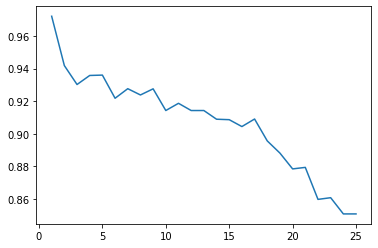

In [15]:
f_score_from_window_parameter = {}
if best_window == 'fixed':
    for h in tqdm(range(min_h, max_h_best + 1)):
        confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
        for excluded_row_index in range(n):
#             write_dataset(dataset, n, m, best_metric, best_kernel, best_window, best_window_parameter, excluded_row_index, input_file_name)
#             predicted_class = get_prediction(input_file_name, output_file_name)
            
            t = dataset.loc[[excluded_row_index]]
            train = dataset.drop(excluded_row_index, axis = 0)
            test = t.drop("class", axis=1)
            y = train["class"].values
            predicted_class = int(round(predict(train, y, test, kernel_functions[best_kernel], distance_functions[best_metric], best_window, h)))
            
            real_class = dataset['class'][excluded_row_index]
            confusion_matrix[real_class][predicted_class] += 1

        f_score = get_f_score_native(classes_number, confusion_matrix)
        f_score_from_window_parameter[h] = f_score
        
else:
    for k in tqdm(range(min_k, max_k_best + 1)):
        confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
        for excluded_row_index in range(n):
#             write_dataset(dataset, n, m, best_metric, best_kernel, best_window, best_window_parameter, excluded_row_index, input_file_name)
#             predicted_class = get_prediction(input_file_name, output_file_name)
            
            t = dataset.loc[[excluded_row_index]]
            train = dataset.drop(excluded_row_index, axis = 0)
            test = t.drop("class", axis=1)
            y = train["class"].values
            predicted_class = int(round(predict(train, y, test, kernel_functions[best_kernel], distance_functions[best_metric], best_window, k)))
        
            real_class = dataset['class'][excluded_row_index]
            confusion_matrix[real_class][predicted_class] += 1

        f_score = get_f_score_native(classes_number, confusion_matrix)
        f_score_from_window_parameter[k] = f_score

pt.plot(list(f_score_from_window_parameter.keys()), list(f_score_from_window_parameter.values()))
pt.savefig("thyroid_trivial.png")
pt.show()

In [16]:
# # One-Hot
# for i in range(classes_number):
#     dataset[f"is_{i}"] = dataset.apply(lambda x: 1 if x['class'] == i else 0, axis = 1)
# dataset.sample(20)

In [17]:
def write_dataset_with_one_hot(dataset, n, m, metric, kernel, window, window_parameter, excluded_row_index, input_file_name, sign):
    input_file = open(input_file_name, 'w')
    input_file.write(f"{n - 1} {m}\n")
    training_rows_indices = list(range(0, n))
    training_rows_indices.remove(excluded_row_index)
    is_sign = f"is_{sign}"
    for j in training_rows_indices:
        for key in dataset.columns[:m]:
            input_file.write(f"{dataset[key][j]} ")
        input_file.write(f"{dataset[is_sign][j]}")
        input_file.write('\n')
    for key in dataset.columns[:m]:
            input_file.write(f"{dataset[key][excluded_row_index]} ")
    input_file.write('\n')
    input_file.write(metric + '\n')
    input_file.write(kernel + '\n')
    input_file.write(window + '\n')
    input_file.write(str(window_parameter))
    input_file.close()

In [18]:
def get_prediction_absolute_value(input_file_name, output_file_name):
    os.system(f"./prediction {input_file_name} {output_file_name}")
    output_file = open(output_file_name, 'r')
    return float(output_file.read())

In [23]:
import copy

best_metric = metrics[0]
best_kernel = kernels[0]
best_window = windows[0]
best_window_parameter = 1

best_f_score = 0.0

to_drop = []
for i in range(classes_number):
    to_drop.append(f"is_{i}")

datasets = []
for c in range(classes_number):
    df = copy.deepcopy(dataset)
    df[f'is_{c}'] = df.apply(lambda x: 1 if x["class"] == c else 0, axis=1)
    datasets.append(df)
    
for metric in tqdm(metrics):
    for kernel in tqdm(kernels):
        print(f"best_f_score: {best_f_score}")
        for window in tqdm(windows):
            if window == 'fixed':
                for h in range(min_h, max_h_train + 1, h_step):
                    confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
                    for excluded_row_index in range(n):
                        max_prediction_confidence = 0.0
                        best_predicted_class = 0
                        for i in range(classes_number):
#                             write_dataset_with_one_hot(dataset, n, m, metric, kernel, window, h, excluded_row_index, input_file_name, i)
#                             prediction_value = get_prediction_absolute_value(input_file_name, output_file_name)
                            
                            df = datasets[i]
                            t = df.loc[[excluded_row_index]]
                            
                            train = df.drop(excluded_row_index, axis = 0).drop('class', axis = 1)
                            test = t.drop(f"is_{i}", axis = 1).drop('class', axis = 1)
                    
                            y = train[f"is_{i}"].values
                            prediction_value = predict(train, y, test, kernel_functions[kernel], distance_functions[metric], window, h)
                            
                            if prediction_value > max_prediction_confidence:
                                max_prediction_confidence = prediction_value
                                best_predicted_class = i
                        
                        real_class = dataset['class'][excluded_row_index]
                        confusion_matrix[real_class][best_predicted_class] += 1

                    f_score = get_f_score_native(classes_number, confusion_matrix)
                    
                    if f_score > best_f_score:
                        best_f_score = f_score
                        best_metric = metric
                        best_kernel = kernel
                        best_window = window
                        best_window_parameter = h
            else:
                for k in range(min_k, max_k_train + 1, k_step):
                    confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
                    for excluded_row_index in range(n):
                        max_prediction_confidence = 0.0
                        best_predicted_class = 0
                        for i in range(classes_number):
#                             write_dataset_with_one_hot(dataset, n, m, metric, kernel, window, k, excluded_row_index, input_file_name, i)
#                             prediction_value = get_prediction_absolute_value(input_file_name, output_file_name)

                            df = datasets[i]
                            t = df.loc[[excluded_row_index]]
                            
                            train = df.drop(excluded_row_index, axis = 0).drop('class', axis = 1)
                            test = t.drop(f"is_{i}", axis = 1).drop('class', axis = 1)
                    
                            y = train[f"is_{i}"].values
                            prediction_value = predict(train, y, test, kernel_functions[kernel], distance_functions[metric], window, k)
    
                            if prediction_value > max_prediction_confidence:
                                max_prediction_confidence = prediction_value
                                best_predicted_class = i
                        
                        real_class = dataset['class'][excluded_row_index]
                        confusion_matrix[real_class][best_predicted_class] += 1

                    f_score = get_f_score_native(classes_number, confusion_matrix)
                    
                    if f_score > best_f_score:
                        best_f_score = f_score
                        best_metric = metric
                        best_kernel = kernel
                        best_window = window
                        best_window_parameter = k
                        
print(f"f score: {best_f_score}")
print(f"metric: {best_metric}")
print(f"kernel: {best_kernel}")
print(f"window type: {best_window}")
print(f"window parameter: {best_window_parameter}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.0




 50%|█████     | 1/2 [00:28<00:28, 28.79s/it]

100%|██████████| 2/2 [00:53<00:00, 26.53s/it]

 10%|█         | 1/10 [00:53<07:57, 53.07s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9721420272898542




 50%|█████     | 1/2 [00:29<00:29, 29.29s/it]

100%|██████████| 2/2 [00:51<00:00, 25.50s/it]

 20%|██        | 2/10 [01:44<06:59, 52.45s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:25<00:25, 25.39s/it]

100%|██████████| 2/2 [00:46<00:00, 23.03s/it]

 30%|███       | 3/10 [02:30<05:53, 50.54s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:25<00:25, 25.97s/it]

100%|██████████| 2/2 [00:47<00:00, 23.66s/it]

 40%|████      | 4/10 [03:17<04:57, 49.57s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:25<00:25, 25.76s/it]

100%|██████████| 2/2 [00:47<00:00, 23.54s/it]

 50%|█████     | 5/10 [04:04<04:04, 48.83s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:26<00:26, 26.38s/it]

100%|██████████| 2/2 [00:47<00:00, 23.88s/it]

 60%|██████    | 6/10 [04:52<03:14, 48.50s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.47s/it]

100%|██████████| 2/2 [00:54<00:00, 27.31s/it]

 70%|███████   | 7/10 [05:46<02:31, 50.34s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:27<00:27, 27.97s/it]

100%|██████████| 2/2 [00:49<00:00, 24.89s/it]

 80%|████████  | 8/10 [06:36<01:40, 50.17s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.81s/it]

100%|██████████| 2/2 [00:55<00:00, 27.70s/it]

 90%|█████████ | 9/10 [07:32<00:51, 51.74s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.66s/it]

100%|██████████| 2/2 [00:54<00:00, 27.37s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.25s/it]

100%|██████████| 2/2 [00:52<00:00, 26.18s/it]

 10%|█         | 1/10 [00:52<07:51, 52.36s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.65s/it]

100%|██████████| 2/2 [00:53<00:00, 26.62s/it]

 20%|██        | 2/10 [01:45<07:01, 52.63s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:30<00:30, 30.06s/it]

100%|██████████| 2/2 [00:54<00:00, 27.28s/it]

 30%|███       | 3/10 [02:40<06:12, 53.21s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:30<00:30, 30.27s/it]

100%|██████████| 2/2 [00:56<00:00, 28.46s/it]

 40%|████      | 4/10 [03:37<05:25, 54.32s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:30<00:30, 30.22s/it]

100%|██████████| 2/2 [00:54<00:00, 27.44s/it]

 50%|█████     | 5/10 [04:31<04:32, 54.49s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:30<00:30, 30.04s/it]

100%|██████████| 2/2 [00:54<00:00, 27.13s/it]

 60%|██████    | 6/10 [05:26<03:37, 54.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:32<00:32, 32.48s/it]

100%|██████████| 2/2 [01:01<00:00, 30.98s/it]

 70%|███████   | 7/10 [06:28<02:50, 56.69s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:31<00:31, 31.39s/it]

100%|██████████| 2/2 [00:56<00:00, 28.06s/it]

 80%|████████  | 8/10 [07:24<01:53, 56.52s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:33<00:33, 33.12s/it]

100%|██████████| 2/2 [01:02<00:00, 31.49s/it]

 90%|█████████ | 9/10 [08:27<00:58, 58.46s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:32<00:32, 32.05s/it]

100%|██████████| 2/2 [01:00<00:00, 30.14s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:24<00:24, 24.25s/it]

100%|██████████| 2/2 [00:44<00:00, 22.31s/it]

 10%|█         | 1/10 [00:44<06:41, 44.62s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:25<00:25, 25.60s/it]

100%|██████████| 2/2 [00:46<00:00, 23.41s/it]

 20%|██        | 2/10 [01:31<06:02, 45.28s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:25<00:25, 25.87s/it]

100%|██████████| 2/2 [00:47<00:00, 23.63s/it]

 30%|███       | 3/10 [02:18<05:21, 45.88s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:25<00:25, 25.89s/it]

100%|██████████| 2/2 [00:47<00:00, 23.63s/it]

 40%|████      | 4/10 [03:05<04:37, 46.29s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.03s/it]

100%|██████████| 2/2 [00:49<00:00, 24.56s/it]

 50%|█████     | 5/10 [03:55<03:55, 47.14s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:26<00:26, 26.41s/it]

100%|██████████| 2/2 [00:47<00:00, 23.74s/it]

 60%|██████    | 6/10 [04:42<03:08, 47.24s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.98s/it]

100%|██████████| 2/2 [00:56<00:00, 28.45s/it]

 70%|███████   | 7/10 [05:39<02:30, 50.14s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:30<00:30, 30.58s/it]

100%|██████████| 2/2 [00:52<00:00, 26.16s/it]

 80%|████████  | 8/10 [06:31<01:41, 50.80s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.96s/it]

100%|██████████| 2/2 [00:56<00:00, 28.02s/it]

 90%|█████████ | 9/10 [07:27<00:52, 52.37s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

best_f_score: 0.9769195571238696




 50%|█████     | 1/2 [00:28<00:28, 28.57s/it]

100%|██████████| 2/2 [00:54<00:00, 27.43s/it]

100%|██████████| 3/3 [26:17<00:00, 525.73s/it]

f score: 0.9769195571238696
metric: manhattan
kernel: triangular
window type: variable
window parameter: 3


In [26]:
f_score_from_window_parameter = {}
max_k_best = 25
max_h_best = 25
if best_window == 'fixed':
    for h in tqdm(range(min_h, max_h_best + 1)):
        confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
        for excluded_row_index in range(n):
            max_prediction_confidence = 0.0
            best_predicted_class = 0
            for i in range(classes_number):
#                 write_dataset_with_one_hot(dataset, n, m, best_metric, best_kernel, best_window, h, excluded_row_index, input_file_name, i)
#                 prediction_value = get_prediction_absolute_value(input_file_name, output_file_name)

                df = datasets[i]
                t = df.loc[[excluded_row_index]]

                train = df.drop(excluded_row_index, axis = 0).drop('class', axis = 1)
                test = t.drop(f"is_{i}", axis = 1).drop('class', axis = 1)

                y = train[f"is_{i}"].values
                prediction_value = predict(train, y, test, kernel_functions[best_kernel], distance_functions[best_metric], best_window, h)
                
                if prediction_value > max_prediction_confidence:
                    max_prediction_confidence = prediction_value
                    best_predicted_class = i

            real_class = dataset['class'][excluded_row_index]
            confusion_matrix[real_class][best_predicted_class] += 1

        f_score = get_f_score_native(classes_number, confusion_matrix)

        if f_score > best_f_score:
            best_f_score = f_score
            best_metric = metric
            best_kernel = kernel
            best_window = window
            best_window_parameter = h
else:
    for k in tqdm(range(min_k, max_k__best + 1, k_step)):
        confusion_matrix = np.zeros((classes_number, classes_number), dtype = np.int32)
        for excluded_row_index in range(n):
            max_prediction_confidence = 0.0
            best_predicted_class = 0
            for i in range(classes_number):
#                 write_dataset_with_one_hot(dataset, n, m, best_metric, best_kernel, best_window, k, excluded_row_index, input_file_name, i)
#                 prediction_value = get_prediction_absolute_value(input_file_name, output_file_name)

                df = datasets[i]
                t = df.loc[[excluded_row_index]]

                train = df.drop(excluded_row_index, axis = 0).drop('class', axis = 1)
                test = t.drop(f"is_{i}", axis = 1).drop('class', axis = 1)

                y = train[f"is_{i}"].values
                prediction_value = predict(train, y, test, kernel_functions[best_kernel], distance_functions[best_metric], best_window, k)
                
                if prediction_value > max_prediction_confidence:
                    max_prediction_confidence = prediction_value
                    best_predicted_class = i

            real_class = dataset['class'][excluded_row_index]
            confusion_matrix[real_class][best_predicted_class] += 1

        f_score = get_f_score_native(classes_number, confusion_matrix)

        if f_score > best_f_score:
            best_f_score = f_score
            best_metric = metric
            best_kernel = kernel
            best_window = window
            best_window_parameter = k

pt.plot(list(f_score_from_window_parameter.keys()), list(f_score_from_window_parameter.values()))
pt.savefig("thyroid_one_hot.png")
pt.show()

NameError: name 'max_k__best' is not defined

In [ ]:
# //
# // Created by damtev on 20.09.2020.
# //

# #define _USE_MATH_DEFINES

# #include <iostream>
# #include <vector>
# #include <cmath>
# #include <unordered_map>
# #include <algorithm>

# namespace metrics {

#   double manhattan_metric(const std::vector<double>& first, const std::vector<double>& second) {
#     const size_t n = first.size();
#     double distance = 0;
#     for (size_t i = 0; i < n; ++i) {
#       distance += std::abs(first[i] - second[i]);
#     }

#     return distance;
#   }

#   double euclidian_metric(const std::vector<double>& first, const std::vector<double>& second) {
#     const size_t n = first.size();
#     double distance = 0;
#     for (size_t i = 0; i < n; ++i) {
#       const double diff = std::abs(first[i] - second[i]);
#       distance += diff * diff;
#     }

#     return sqrt(distance);
#   }

#   double chebyshev_metric(const std::vector<double>& first, const std::vector<double>& second) {
#     const size_t n = first.size();
#     double distance = 0;
#     for (size_t i = 0; i < n; ++i) {
#       const double diff = std::abs(first[i] - second[i]);
#       distance = std::max(distance, diff);
#     }

#     return distance;
#   }
# }

# namespace kernels {

#   double uniform_kernel(const double distance) {
#     if (distance > -1 && distance < 1) {
#       return 0.5;
#     } else {
#       return 0;
#     }
#   }

#   double triangular_kernel(const double distance) {
#     if (distance > -1 && distance < 1) {
#       return 1 - std::abs(distance);
#     } else {
#       return 0;
#     }
#   }

#   double epanechnikov_kernel(const double distance) {
#     if (distance > -1 && distance < 1) {
#       return 0.75 * (1 - distance * distance);
#     } else {
#       return 0;
#     }
#   }

#   double quartic_kernel(const double distance) {
#     if (distance > -1 && distance < 1) {
#       return 15.0 / 16 * pow(1 - distance * distance, 2);
#     } else {
#       return 0;
#     }
#   }

#   double triweight_kernel(const double distance) {
#     if (distance > -1 && distance < 1) {
#       return 35.0 / 32 * pow(1 - distance * distance, 3);
#     } else {
#       return 0;
#     }
#   }

#   double tricube_kernel(const double distance) {
#     if (distance > -1 && distance < 1) {
#       return 70.0 / 81 * pow(1 - pow(std::abs(distance), 3), 3);
#     } else {
#       return 0;
#     }
#   }

#   double gaussian_kernel(const double distance) {
#     return pow(M_E, -(distance * distance) / 2) / sqrt(M_PI * 2);
#   }

#   double cosine_kernel(const double distance) {
#     if (distance > -1 && distance < 1) {
#       return (M_PI / 4 * cos(M_PI / 2 * distance));
#     } else {
#       return 0;
#     }
#   }

#   double logistic_kernel(const double distance) {
#     return 1 / (pow(M_E, distance) + 2 + pow(M_E, -distance));
#   }

#   double sigmoid_kernel(const double distance) {
#     return 2 / M_PI / (pow(M_E, distance) + pow(M_E, -distance));
#   }
# }

# using DistanceFunction = double (*)(const std::vector<double>&, const std::vector<double>&);
# using KernelFunction = double (*)(const double);

# // usage: <input_file> <output_file>
# int main(int args, char* argv[]) {
#   using namespace metrics;
#   using namespace kernels;
#   const std::unordered_map<std::string, DistanceFunction> metrics = {
#       {"manhattan", &manhattan_metric},
#       {"euclidean", &euclidian_metric},
#       {"chebyshev", &chebyshev_metric}
#   };
#   const std::unordered_map<std::string, KernelFunction> kernels = {
#       {"uniform", &uniform_kernel},
#       {"triangular", &triangular_kernel},
#       {"epanechnikov", &epanechnikov_kernel},
#       {"quartic", &quartic_kernel},
#       {"triweight", &triweight_kernel},
#       {"tricube", &tricube_kernel},
#       {"gaussian", &gaussian_kernel},
#       {"cosine", &cosine_kernel},
#       {"logistic", &logistic_kernel},
#       {"sigmoid", &sigmoid_kernel}
#   };

#   std::freopen(argv[1], "r", stdin);
#   std::freopen(argv[2], "w", stdout);

#   size_t n, m;
#   std::cin >> n >> m;

#   std::vector<std::vector<double>> objects_signs(n);
#   std::vector<double> objects_values(n);
#   for (size_t i = 0; i < n; ++i) {
#     objects_signs[i].resize(m);
#     for (size_t j = 0; j < m; ++j) {
#       std::cin >> objects_signs[i][j];
#     }
#     std::cin >> objects_values[i];
#   }

#   std::vector<double> request_signs(m);
#   for (size_t i = 0; i < m; ++i) {
#     std::cin >> request_signs[i];
#   }

#   std::string metric_type, kernel_type, window_type;
#   std::cin >> metric_type >> kernel_type >> window_type;

#   double window_parameter;
#   std::cin >> window_parameter;

#   std::vector<double> distances;
#   distances.reserve(m);
#   for (size_t i = 0; i < n; ++i) {
#     auto& signs = objects_signs[i];
#     signs.push_back(objects_values[i]);
#     signs.push_back(metrics.at(metric_type)(request_signs, signs));
#   }

#   std::sort(objects_signs.begin(), objects_signs.end(), [](std::vector<double>& a, std::vector<double>& b) -> bool {
#     return a.back() < b.back();
#   });

#   double numerator = 0;
#   double denominator = 0;
#   if (window_type == "fixed") {
#     for (size_t i = 0; i < n; ++i) {
#       const auto& signs = objects_signs[i];
#       const double distance = signs.back();
#       const size_t size = signs.size();
#       const double object_value = signs[size - 2];
#       double kernel_value;
#       if (window_parameter != 0) {
#         kernel_value = kernels.at(kernel_type)(distance / window_parameter);
#       } else {
#         kernel_value = kernels.at(kernel_type)(distance == 0 ? 0 : std::numeric_limits<double>::infinity());
#       }
#       numerator += object_value * kernel_value;
#       denominator += kernel_value;
#     }
#   } else {
#     for (size_t i = 0; i < n; ++i) {
#       const auto& signs = objects_signs[i];
#       const double distance = signs.back();
#       const size_t size = signs.size();
#       const double not_neihbor_distance = objects_signs[window_parameter].back();
#       const double object_value = signs[size - 2];
#       double kernel_value;
#       if (not_neihbor_distance != 0) {
#         kernel_value = kernels.at(kernel_type)(distance / not_neihbor_distance);
#       } else {
#         kernel_value = kernels.at(kernel_type)(distance == 0 ? 0 : std::numeric_limits<double>::infinity());
#       }
#       numerator += object_value * kernel_value;
#       denominator += kernel_value;
#     }
#   }

#   std::cout.precision(10);
#   std::cout.setf(std::ios::fixed);
#   if (denominator != 0) {
#     std::cout << (numerator / denominator);
#   } else {
#     double average_sum = 0;
#     for (const double object_value : objects_values) {
#       average_sum += object_value;
#     }
#     average_sum /= n;
#     std::cout << average_sum;
#   }

#   std::fclose(stdin);
#   std::fclose(stdout);

#   return 0;
# }

In [ ]:
# //
# // Created by damtev on 16.09.2020.
# //

# #include <iostream>
# #include <vector>

# // usage: <input_file> <output_file>
# int main(int argc, char* argv[]) {
#   std::freopen(argv[1], "r", stdin);
#   std::freopen(argv[2], "w", stdout);

#   size_t classes_number;
#   std::cin >> classes_number;
#   std::vector<std::vector<size_t>> confusion_matrix(classes_number);
#   std::vector<size_t> rows_sum(classes_number);
#   std::vector<size_t> columns_sum(classes_number);
#   size_t all_sum = 0;
#   for (size_t i = 0; i < classes_number; ++i) {
#     confusion_matrix.reserve(classes_number);
#     for (size_t j = 0; j < classes_number; ++j) {
#       size_t value;
#       std::cin >> value;
#       confusion_matrix[i].push_back(value);
#       rows_sum[i] += value;
#       columns_sum[j] += value;
#       all_sum += value;
#     }
#   }

#   double micro_f = 0.0;
#   double average_precision = 0.0;
#   double average_recall = 0.0;
#   for (size_t class_index = 0; class_index < classes_number; ++class_index) {
#     size_t true_positive = confusion_matrix[class_index][class_index];
#     size_t false_positive = rows_sum[class_index] - confusion_matrix[class_index][class_index];
#     size_t false_negative = columns_sum[class_index] - confusion_matrix[class_index][class_index];

#     double precision =
#         true_positive + false_positive == 0 ? 0 : (double) true_positive / (double) (true_positive + false_positive);
#     double recall =
#         true_positive + false_negative == 0 ? 0 : (double) true_positive / (double) (true_positive + false_negative);

#     micro_f += precision + recall == 0 ? 0 : rows_sum[class_index] * 2.0 * precision * recall / (precision + recall);
#     average_precision += rows_sum[class_index] * precision;
#     average_recall += rows_sum[class_index] * recall;
#   }

#   double macro_f = 2.0 * average_precision * average_recall / (average_precision + average_recall) / all_sum;
#   micro_f /= all_sum;

#   std::cout << macro_f;

#   std::fclose(stdin);
#   std::fclose(stdout);

#   return 0;
# }